In [ ]:
# default_exp sparse.criteria

# Criteria

>  Which parameter is important in a neural network ?

In [ ]:
#all_slow

In [ ]:
#export
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.basics import *
from fastcore.imports import *

The criteria implemented come from [this paper](https://arxiv.org/pdf/1905.01067.pdf).

In [ ]:
#hide
import matplotlib.pyplot as plt
import numpy as np

from fastai.vision.all import *
from fasterai.sparse.all import *

%config InlineBackend.figure_format='retina'

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='poster', style='white', font='sans-serif', font_scale=1, color_codes=True, rc=None)


limit = np.linspace(-1, 1, 100)

def demo_model(criteria, sparsity=50):
    model = models.resnet18(pretrained=True)
    
    sp = Sparsifier(model.conv1, 'weight', 'local', criteria)
    
    pt = model.conv1.weight.clone().view(-1).detach().numpy()
    model.conv1.weight.data += 0.05*torch.randn(model.conv1.weight.shape)
    ft = model.conv1.weight.clone().view(-1).detach().numpy()
    sp.prune_model(sparsity)
    keep = np.where(model.conv1._mask.view(-1)==1)
    pruned = np.where(model.conv1._mask.view(-1)==0)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    x1, x2, y1, y2 = -0.4, 0.4, -0.4, 0.4 # specify the limits
    ax.set_xlim(x1, x2) # apply the x-limits
    ax.set_ylim(y1, y2) # apply the x-limits
    ax.scatter(pt[pruned], ft[pruned], s=5, c='lightgrey')
    ax.scatter(pt[keep], ft[keep], s=5, c='teal')
    ax.plot(limit, limit, c='black', linestyle=':')
    ax.set_xlabel("Pretrained Weights")
    ax.set_ylabel("Fine-Tuned Weights")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [ ]:
#export
granularities = {'channel':1, 'vector':2, 'row':3, 'kernel':(2,3), 'filter':(1,2,3)}

class Criteria():
    def __init__(self, f, needs_init=False, needs_update=False, output_f=None, return_init=False):
        store_attr()
        assert (needs_init and needs_update)==False, "The init values will be overwritten by the updating ones."
    
    def __call__(self, m, granularity):
        if self.needs_update and hasattr(m, '_old_weights') == False:
            m.register_buffer("_old_weights", m._init_weights.clone()) # If the previous value of weights is not known, take the initial value
        
        if granularity == 'weight':
            wf = self.f(m.weight)
            if self.needs_init: wi = self.f(m._init_weights)
            elif self.needs_update: wi = self.f(m._old_weights)

        elif granularity in granularities:
            dim = granularities[granularity]
            wf = self.f(m.weight).mean(dim=dim, keepdim=True)
            if self.needs_init: wi = self.f(m._init_weights).mean(dim=dim, keepdim=True)
            elif self.needs_update: wi = self.f(m._old_weights).mean(dim=dim, keepdim=True)

        else: raise NameError('Invalid Granularity')
            
        if self.needs_update: m._old_weights = m.weight.clone() # The current value becomes the old one for the next iteration
        
        if self.output_f: return self.output_f(wf, wi)
        elif self.return_init: return wi
        else: return wf

## Weight Based Criteria

### Random

In [ ]:
#export
random = Criteria(torch.randn_like)

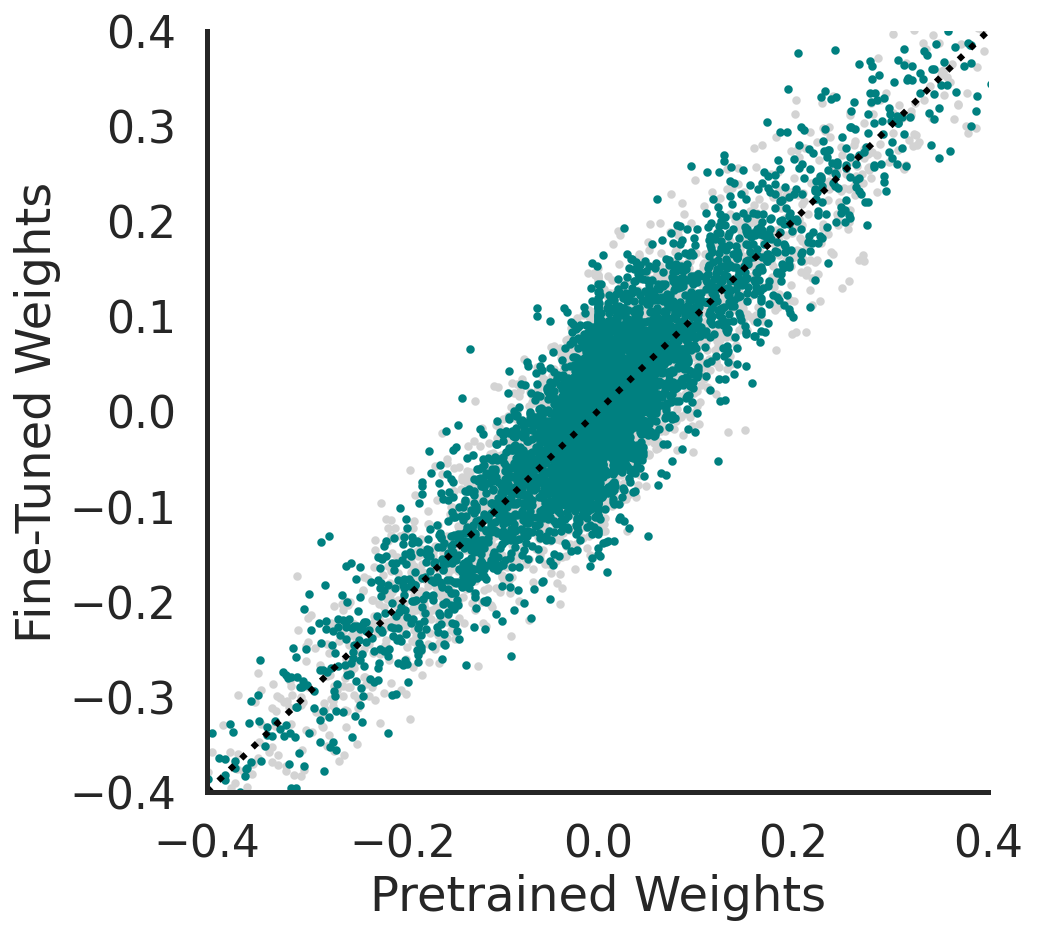

In [ ]:
demo_model(random)

### Large Final Value

In [ ]:
#export
large_final = Criteria(torch.abs)

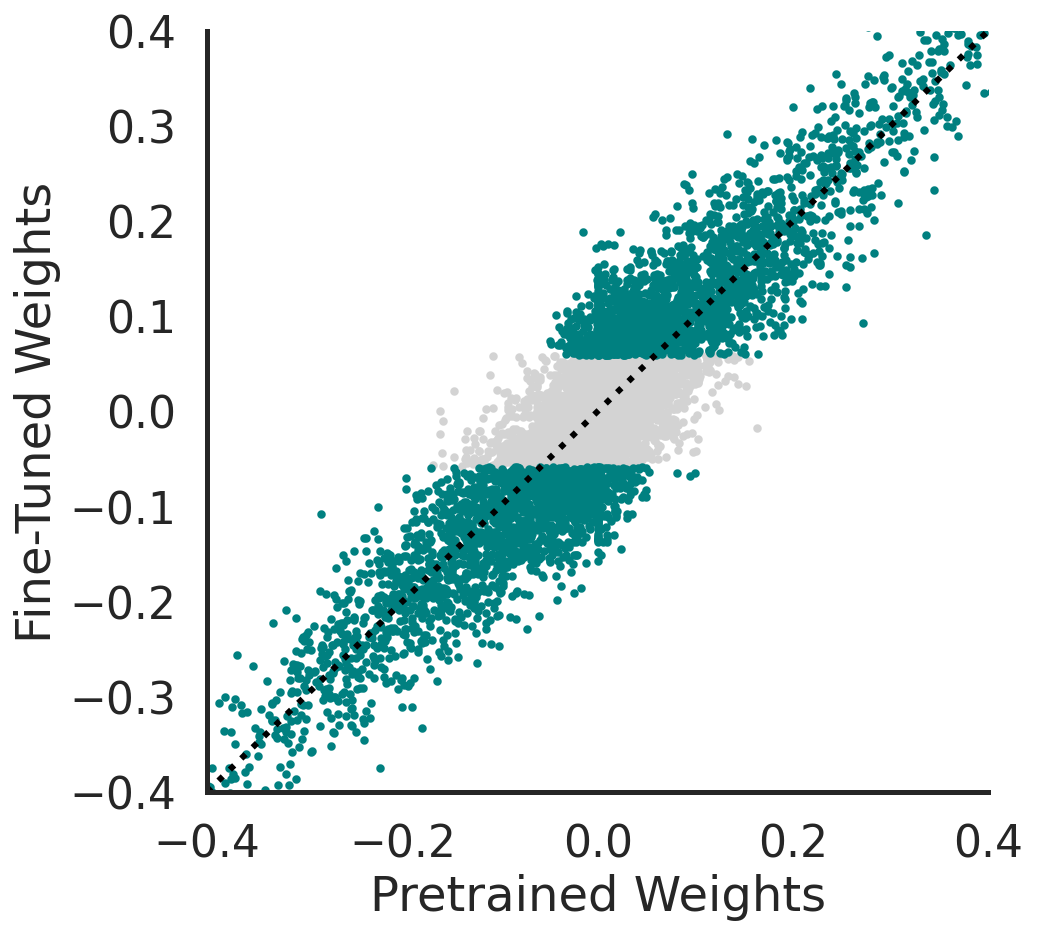

In [ ]:
demo_model(large_final)

### Small Final Value

In [ ]:
#export
small_final = Criteria(compose(torch.abs, torch.neg))

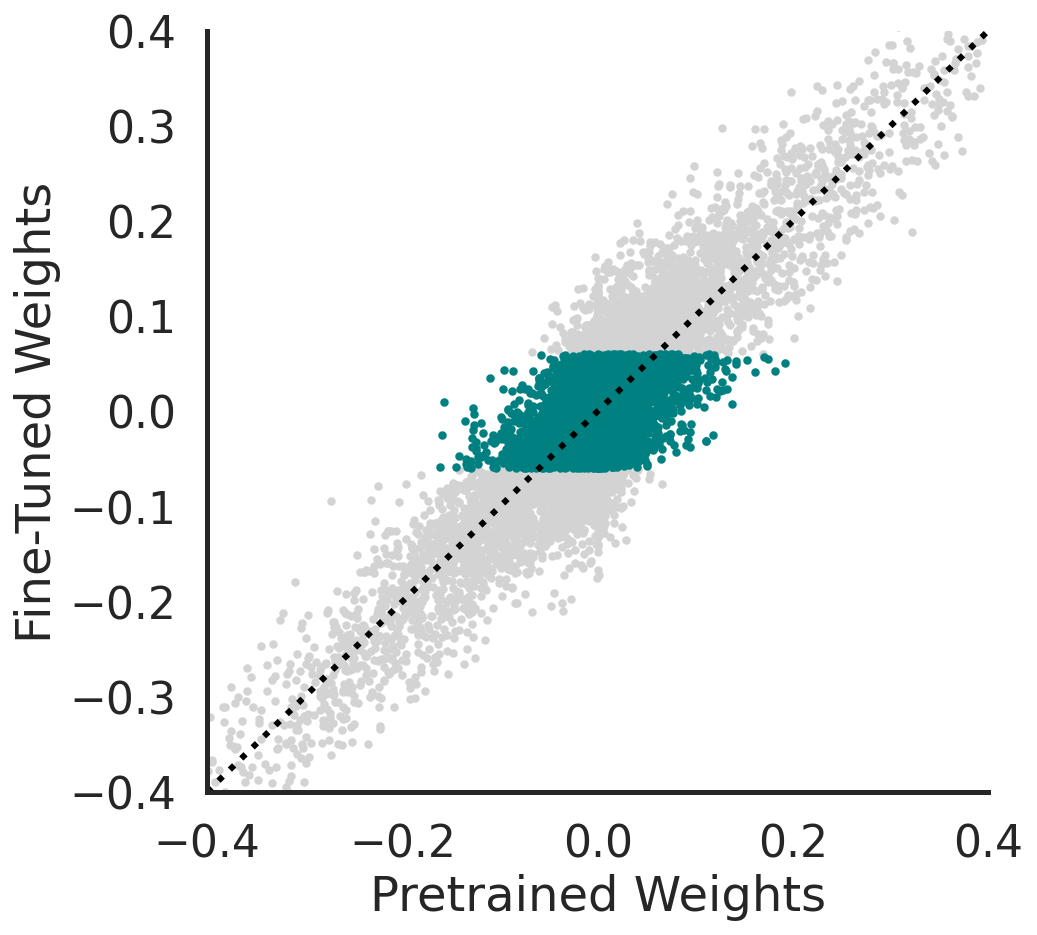

In [ ]:
demo_model(small_final)

### Large Init Value

In [ ]:
#export
large_init = Criteria(torch.abs, needs_init=True, return_init=True)

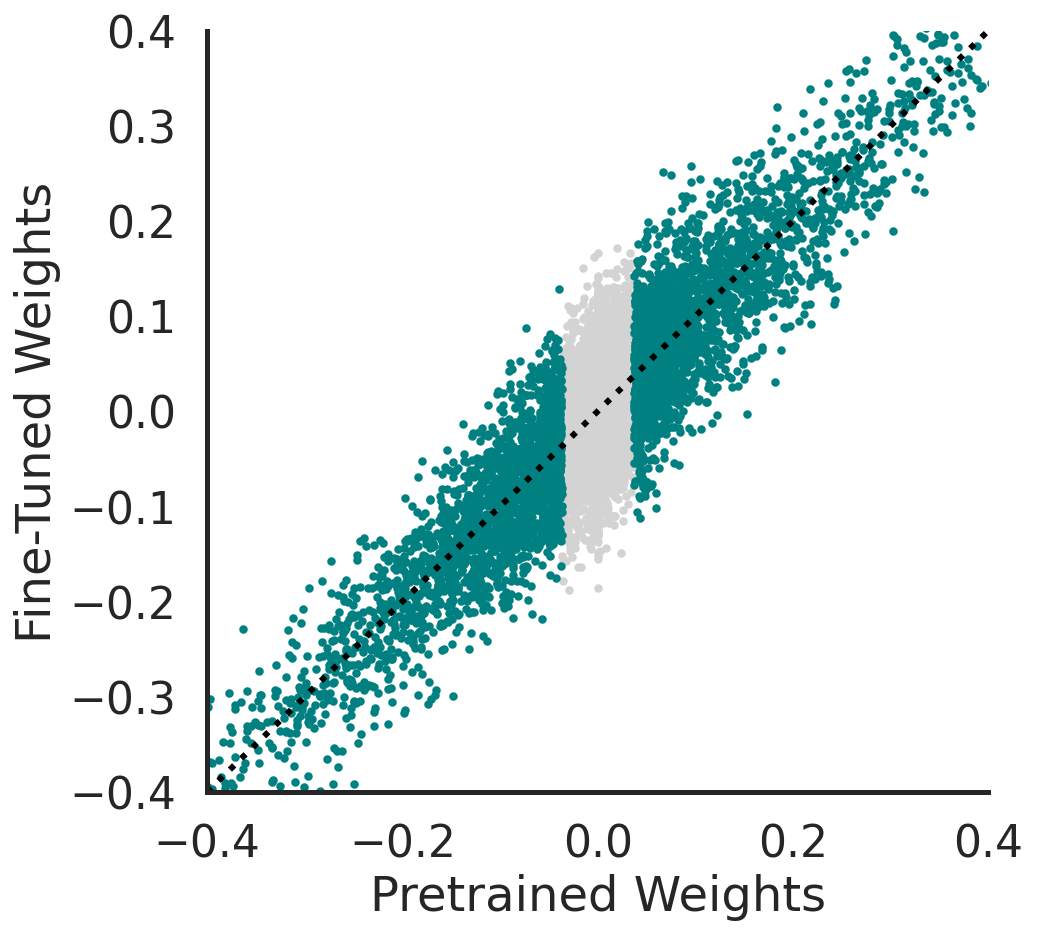

In [ ]:
demo_model(large_init)

### Small Init Value

In [ ]:
#export
small_init = Criteria(compose(torch.abs, torch.neg), needs_init=True, return_init=True)

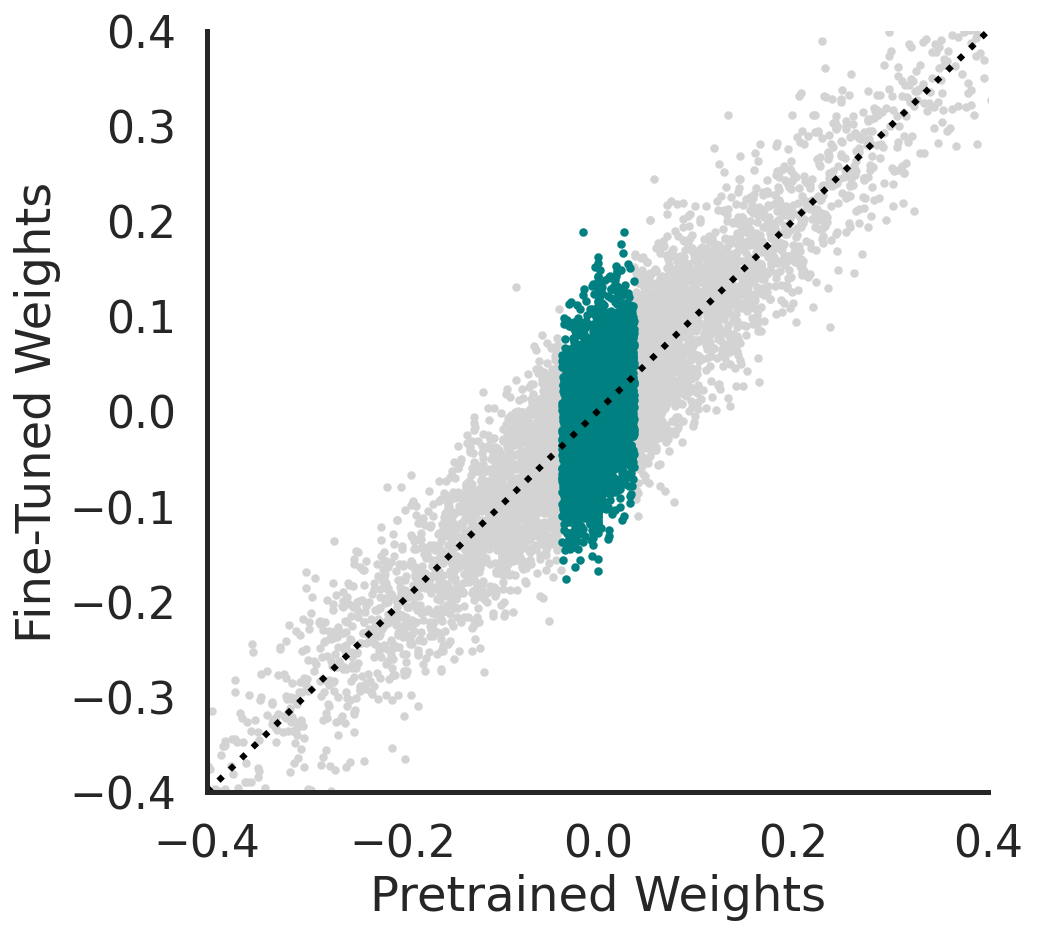

In [ ]:
demo_model(small_init)

### Large Init Large Final Value

In [ ]:
#export
large_init_large_final = Criteria(torch.abs, needs_init=True, output_f=torch.min)

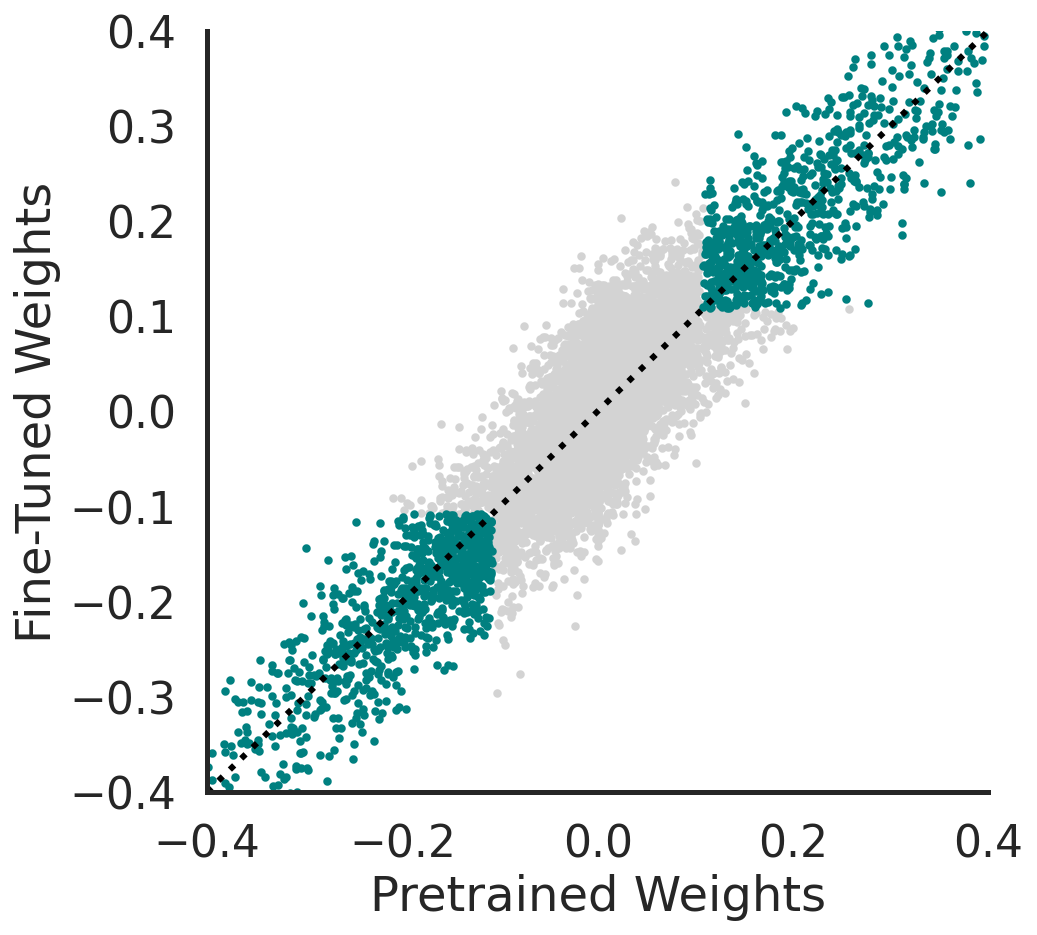

In [ ]:
demo_model(large_init_large_final, 80)

### Small Init Small Final Value

In [ ]:
#export
small_init_small_final = Criteria(torch.abs, needs_init=True, output_f=lambda x,y: torch.neg(torch.max(x,y)))

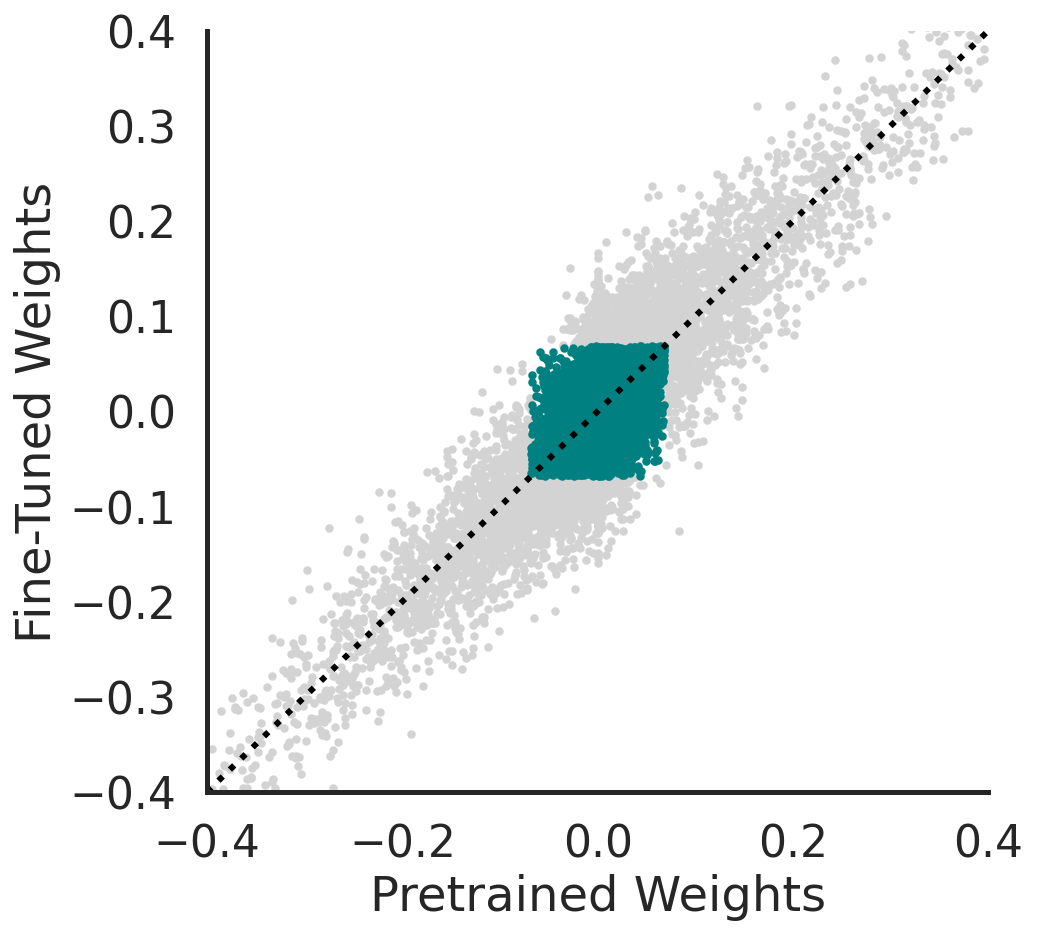

In [ ]:
demo_model(small_init_small_final)

### Increasing Magnitude

In [ ]:
#export
magnitude_increase = Criteria(torch.abs, needs_init=True, output_f= torch.sub)

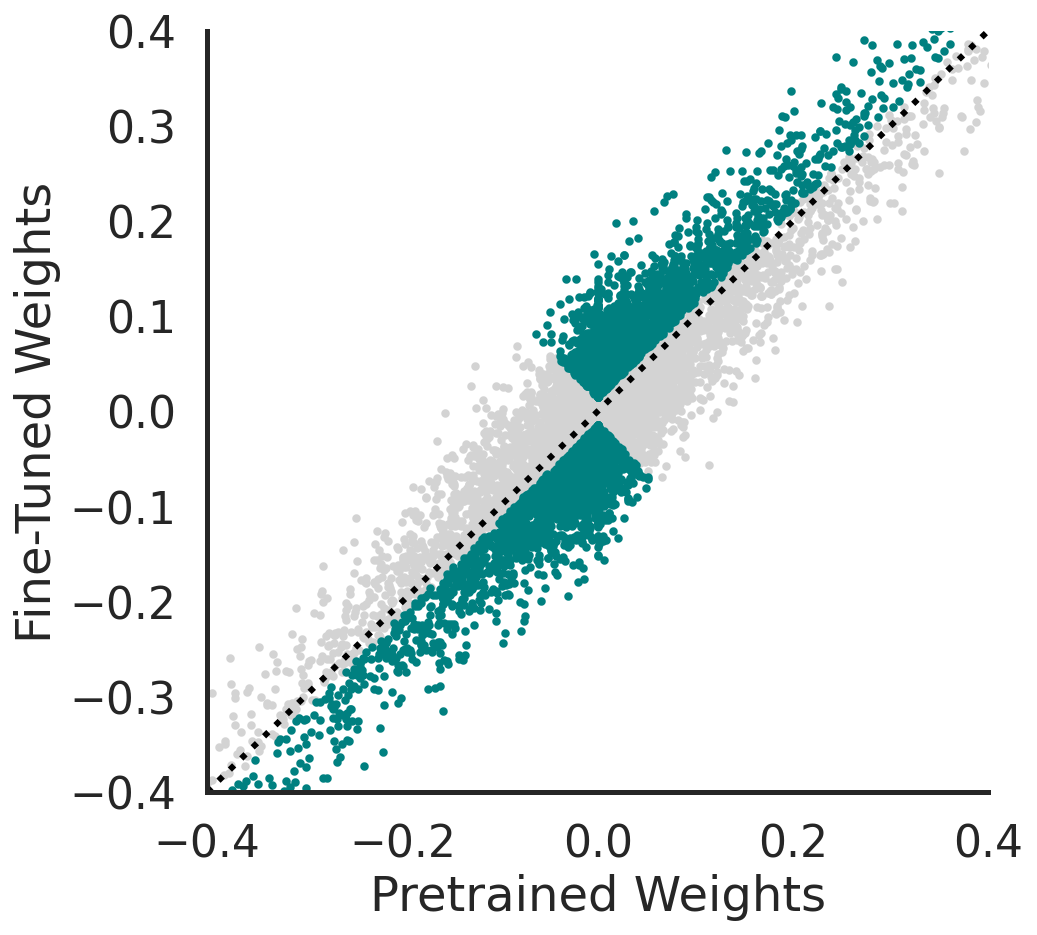

In [ ]:
demo_model(magnitude_increase)

### Movement Pruning

In [ ]:
#export
movement = Criteria(noop, needs_init=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

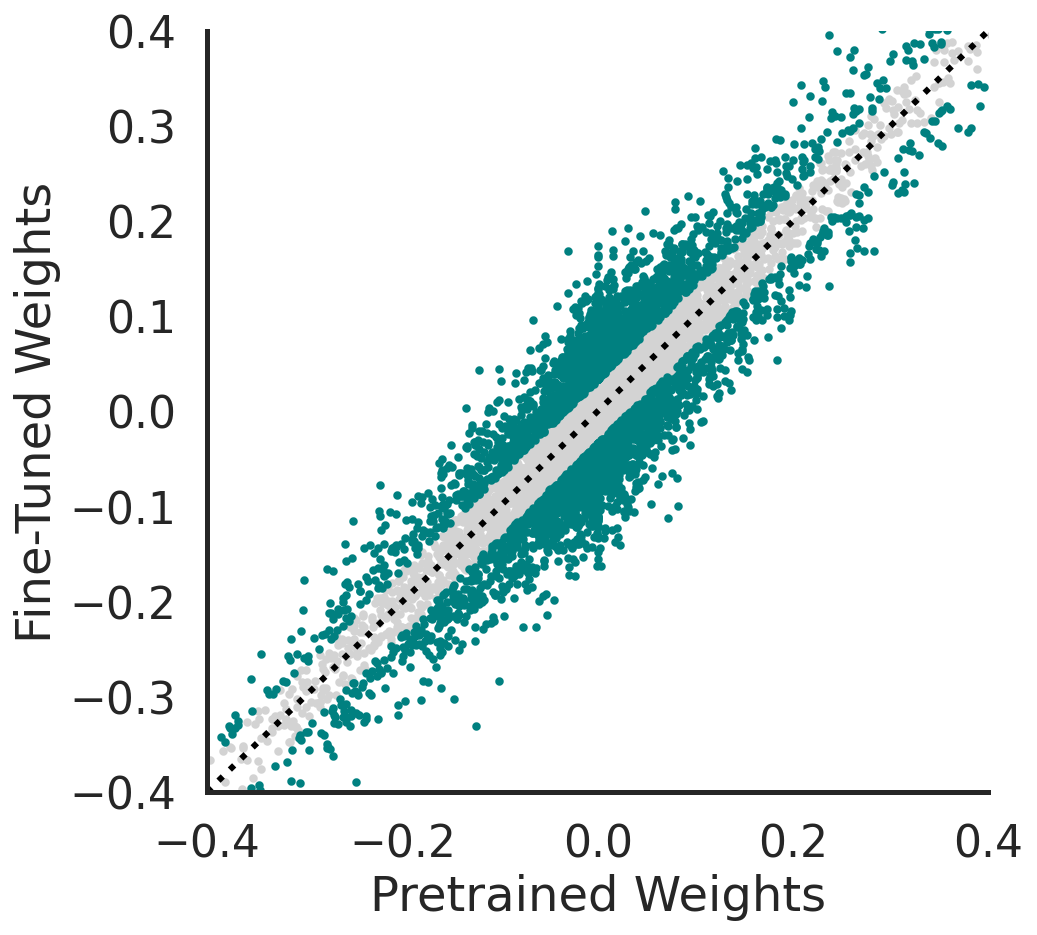

In [ ]:
demo_model(movement)

## Updating Versions

The following criteria use an updating value of the weights, i.e. the value from the previous iteration of training, instead of the initialization value to better capture the training dynamics.

### Updating Magnitude Increase

In [ ]:
#export
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_f= torch.sub)

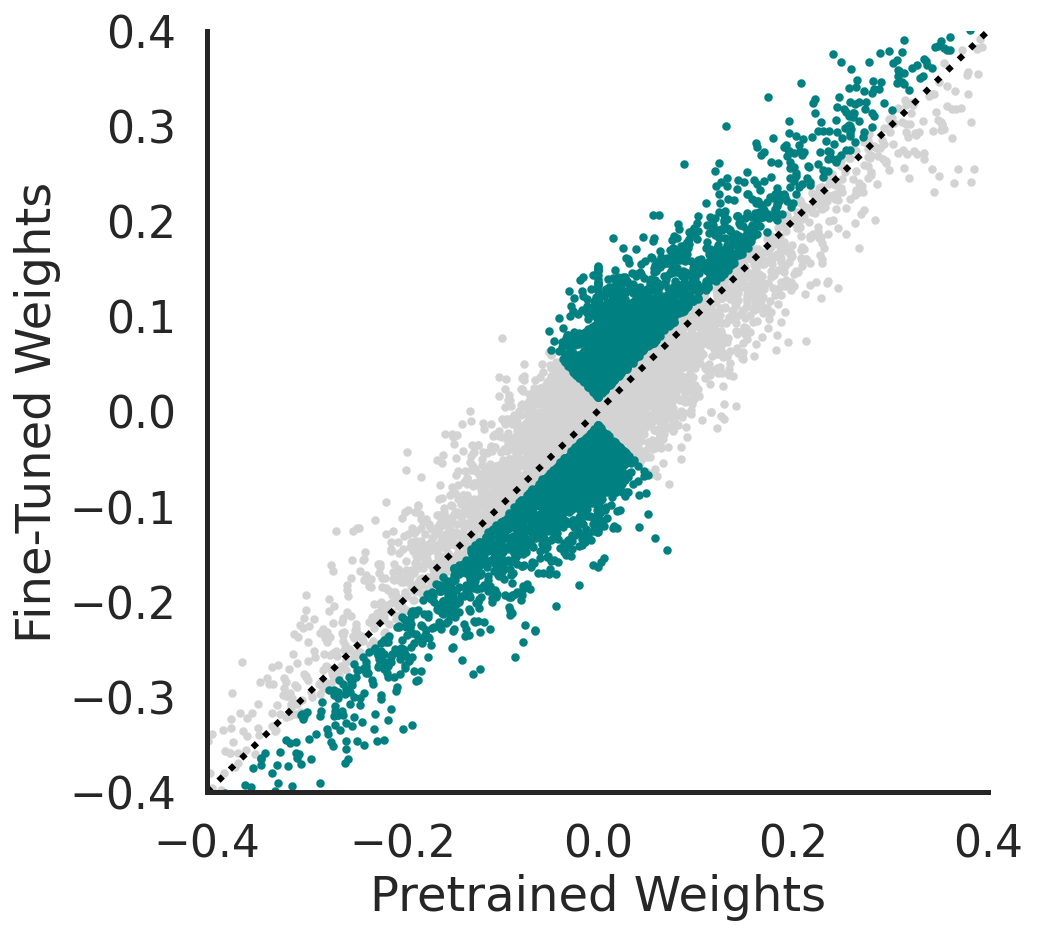

In [ ]:
demo_model(updating_magnitude_increase)

### Updating Movement

In [ ]:
#export
updating_movement = Criteria(noop, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

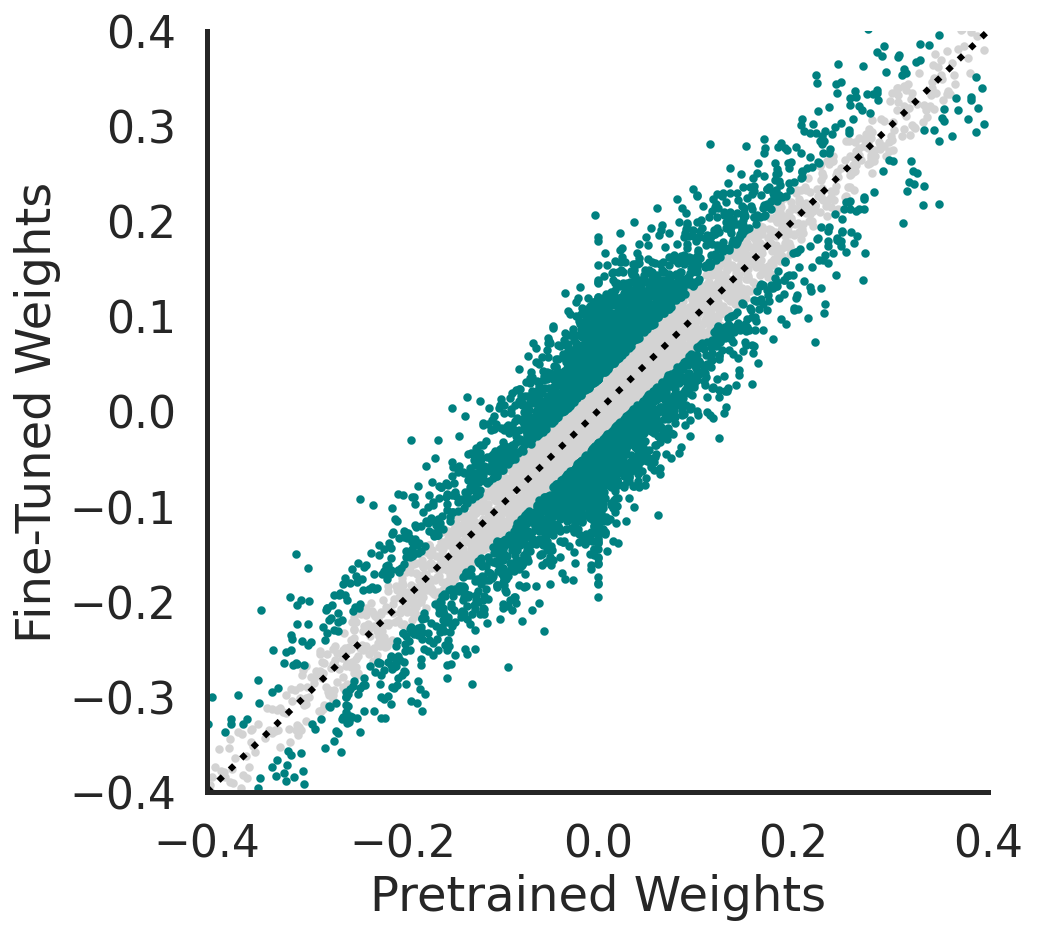

In [ ]:
demo_model(updating_movement)

## Gradient Based Criteria

### First order Taylor expansion on the weight (as per [Nvidia Taylor Pruning](https://github.com/NVlabs/Taylor_pruning/blob/master/pruning_engine.py))

In [ ]:
#export
def grad_crit(m, granularity):
    if m.weight.grad is not None:
        if granularity == 'weight':
            w = (m.weight*m.weight.grad).pow(2)

        elif granularity in granularities:
            dim = granularities[granularity]
            w = (m.weight*m.weight.grad).pow(2).mean(dim=dim, keepdim=True)

        else: raise NameError('Invalid Granularity') 

        return w